## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample
import scipy
import sklearn.model_selection as skl

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
43422,00011197_000.png,No Finding,0,11197,57,M,PA,2992,2991,0.143,0.143,NaN,/data/images_005/images/00011197_000.png
84646,00020834_000.png,No Finding,0,20834,56,M,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00020834_000.png
9742,00002524_021.png,Effusion,21,2524,51,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00002524_021.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head(4)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['Pneumonia Class'] = all_xray_df['Pneumonia'].map(lambda finding: 1.0 if finding == 1.0 else 0)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia Class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
all_xray_df.loc[all_xray_df['Pneumonia'] == 1.0]
all_xray_df['Pneumonia Class'].value_counts()#/len(all_xray_df)


0.0    110689
1.0      1431
Name: Pneumonia Class, dtype: int64

#should we remove the patient entries where age is larger than 110 like we did in our EDA before training? -No

## Create your training and testing data:

In [6]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    ## split the dataset's POSITIVE cases- 80, 20
    train_data, val_data = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia Class'])
    
    ## check how our data is split
    print("POSITIVE PNEUM. CASES SPLIT")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    
    ## throw away some data from the train_data set so that we 
    ## have equal proportions of cases with and without pneumonia
    pneum_inds = train_data[train_data['Pneumonia Class'] == 1].index.tolist()
    no_pneum_inds = train_data[train_data['Pneumonia Class'] == 0].index.tolist()
    
    no_pneum_sample = sample(no_pneum_inds, len(pneum_inds))
    train_data = train_data.loc[pneum_inds + no_pneum_sample]
    
    ## check how our data is split
    print("TRAINING SET BALANCED")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    ## balance the validation set so that the set has a 20-80% proportion
    ## 20% pneumonia positive and 80% negative for pneumonia to reflect the
    ## real-world imbalance 
    p_inds = val_data[val_data['Pneumonia Class'] == 1].index.tolist()
    np_inds = val_data[val_data['Pneumonia Class'] == 0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    print("VAL. SET BALANCED")
    print(len(train_data))
    print(train_data['Pneumonia Class'].value_counts())
    print(len(val_data))
    print(val_data['Pneumonia Class'].value_counts())
    
    return train_data, val_data

In [7]:
train_df, val_df = create_splits(all_xray_df)

POSITIVE PNEUM. CASES SPLIT
89696
0.0    88551
1.0     1145
Name: Pneumonia Class, dtype: int64
22424
0.0    22138
1.0      286
Name: Pneumonia Class, dtype: int64
TRAINING SET BALANCED
2290
0.0    1145
1.0    1145
Name: Pneumonia Class, dtype: int64
22424
0.0    22138
1.0      286
Name: Pneumonia Class, dtype: int64
VAL. SET BALANCED
2290
0.0    1145
1.0    1145
Name: Pneumonia Class, dtype: int64
1430
0.0    1144
1.0     286
Name: Pneumonia Class, dtype: int64


In [8]:
len(train_df)

2290

In [9]:
len(val_df)

1430

In [10]:
train_df['Pneumonia'].sum()/len(train_df)

0.5

In [11]:
val_df['Pneumonia'].sum()/len(val_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale = 1.0/255.0,
                                horizontal_flip = False, 
                                vertical_flip = False,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1, 
                                rotation_range = 20, #rotate by a 20 degree angle
                                shear_range = 0.1,
                                zoom_range = 0.1
                               )
    
    return my_idg


def make_train_gen(train_df, IMG_SIZE = (224,224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    my_train_idg = my_image_augmentation()   
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'Pneumonia Class',
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = 65
                                         )

    return train_gen


def make_val_gen(val_df, IMG_SIZE = (224,224)):
    my_val_idg = my_image_augmentation()
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'Pneumonia Class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 65
                                            ) 
    
    return val_gen

In [13]:
## modfiy Pneumonia Class column so values are of string type 
## inorder to use class_mode = 'binary' in creating our training and validation gens
train_df['Pneumonia Class'] = train_df['Pneumonia Class'].astype('str')
val_df['Pneumonia Class'] = val_df['Pneumonia Class'].astype('str')

In [14]:
train_df['path']

103899    /data/images_011/images/00027725_073.png
9508      /data/images_002/images/00002469_003.png
22198     /data/images_003/images/00005892_001.png
4928      /data/images_001/images/00001317_002.png
26758     /data/images_004/images/00007007_002.png
                            ...                   
17818     /data/images_003/images/00004808_057.png
9640      /data/images_002/images/00002505_010.png
80231     /data/images_009/images/00019718_008.png
106309    /data/images_012/images/00028628_008.png
18237     /data/images_003/images/00004858_051.png
Name: path, Length: 2290, dtype: object

In [15]:
## 07/18/20
## create our augmented image training and validation datasets
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

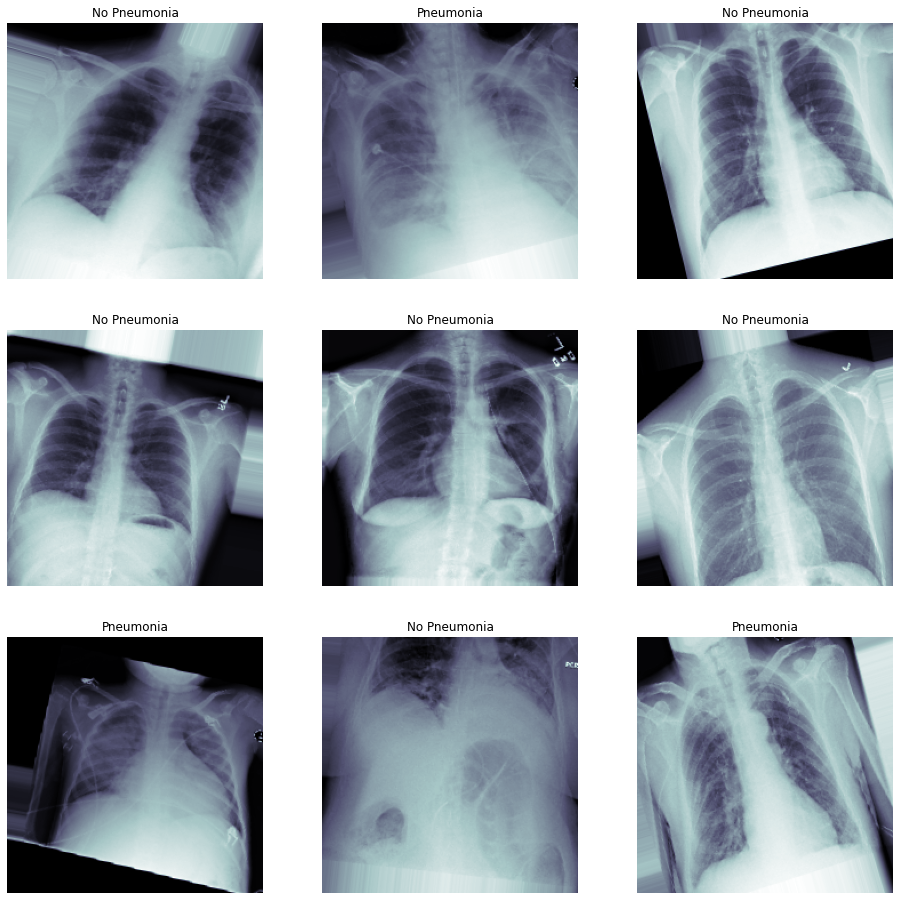

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

## Since our batches are each of size 9, the following code only displays 9 images (1 batch)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')


## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool') #include all convolutional layers of vgg16 model
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
#     vgg_model.summary() #vgg_model only consists of the convolutional layers (up to block5_pool) & no dense layers
                        #since we set outputs in Model() to be the last convolutional layer, excluding the dense, fully connected layers
                        #it is our job to implement the appropriate combination of dense layers and drop out
                        #along with activation functions to optimize our model
    
    return vgg_model


In [19]:
## 07/19/20 - Testing load_pretrained_model()
vgg_model = load_pretrained_model()
len(vgg_model.layers)

553467904/553467096 [==============================] - 7s 0us/step


19

In [20]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [21]:
def build_my_model():
    
    ## in this function, you'll set the dense layers for your model, since so far, your model only consists
    ## of convolutional layers that were pretrained on imagenet weights. In order to actually predict results,
    ## you must flatten output, add dense layers, dropout, and set optimizer loss functions, and metrics
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    my_model = Sequential()
    
    ## freeze conv. layers
    vgg_model = load_pretrained_model()
    ## the following freezes all but the last convolutional layer(block5_conv3)
    ## and consequently, the last pooling layer(block5_pool)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    print(type(vgg_model.layers[1])) ##just for curiosity - is a layer a tensor?
    ## check that appropriate layers were frozen
    for layer in vgg_model.layers:
        print(layer.name, layer.trainable)
    
    ## add pretrained model (frozen conv. layers)
    my_model.add(vgg_model)
    
    ## add any dense layers + dropout 
    ## plan: add three dense layers with dropout (add dropout before each
    ## dense layer, and you add flatten after the frozen conv.layers)
    my_model.add(Flatten())
    
    ##changed all dropouts from 0.3 -> 0.5
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation= 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation= 'sigmoid')) # use sigmoid bc we are doing a binary classification 
                                                  # (not multiclass)
    
    ## compile model
    my_model.compile(optimizer= Adam(learning_rate = .0005), #1e-4
                     loss = 'binary_crossentropy',
                     metrics = ['binary_accuracy'])
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [22]:
my_model = build_my_model()

<class 'keras.layers.convolutional.Conv2D'>
input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [23]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", #CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE
                             verbose=1, 
                             save_best_only=True, 
                             mode= "min",#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", #SAME_AS_METRIC_CHOSEN_ABOVE, 
                      mode= 'min',#CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                      patience=15)

callbacks_list = [checkpoint, early]

### Start training! 

In [24]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, #(valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)

Epoch 1/40
36/36 [==============================] - 93s 3s/step - loss: 0.7984 - binary_accuracy: 0.5240 - val_loss: 0.6581 - val_binary_accuracy: 0.6217

Epoch 00001: val_loss improved from inf to 0.65809, saving model to xray_class_my_model.best.hdf5
Epoch 2/40
36/36 [==============================] - 68s 2s/step - loss: 0.6805 - binary_accuracy: 0.5747 - val_loss: 0.6110 - val_binary_accuracy: 0.6140

Epoch 00002: val_loss improved from 0.65809 to 0.61103, saving model to xray_class_my_model.best.hdf5
Epoch 3/40
36/36 [==============================] - 68s 2s/step - loss: 0.6665 - binary_accuracy: 0.5904 - val_loss: 0.7559 - val_binary_accuracy: 0.4252

Epoch 00003: val_loss did not improve from 0.61103
Epoch 4/40
36/36 [==============================] - 69s 2s/step - loss: 0.6566 - binary_accuracy: 0.6144 - val_loss: 0.6210 - val_binary_accuracy: 0.5503

Epoch 00004: val_loss did not improve from 0.61103
Epoch 5/40
36/36 [==============================] - 68s 2s/step - loss: 0.6517

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [25]:
# len(val_gen) #val_gen holds ALL batches

In [26]:
# valX #valX is only 1 batch (65 samples)

In [27]:
# len(valX)

In [28]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 65, verbose = True)

65/65 [==============================] - 1s 12ms/step


In [29]:
# pred_Y
#len(pred_Y)

In [30]:
# len(pred_Y)

In [31]:
# valY

In [32]:
# len(valY)

In [33]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    ##CONFIRM WHAT IS MEANT BY 'PLOT' AUC
    roc_auc = auc(fpr,tpr)
    print('AUC is ', roc_auc)
    return

## what other performance statistics do you want to include here besides AUC? 
def plot_roc(true_y,pred_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(true_y, pred_y) 
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return fpr, tpr

def plot_precision_recall_curve(true_y,pred_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(true_y, pred_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(true_y,pred_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    return precision, recall, thresholds
    
#Also consider plotting the history of your model training:
def plot_history(history):
    
    # set up
    N = len(history.history["loss"])
    fig, (plt_loss, plt_acc) = plt.subplots(1, 2, figsize=(15,10))    
    
    #plot loss and val_loss on one graph
    plt_loss.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt_loss.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt_loss.set_title("Training Loss on Dataset")
    plt_loss.set(xlabel = "Epoch #", ylabel = "Loss")
    plt_loss.legend(loc="lower left")
    
    #plot acc and val_acc on another graph
    plt_acc.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt_acc.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt_acc.set_title("Training Acc on Dataset")
    plt_acc.set(xlabel = "Epoch #", ylabel = "Accuracy")
    plt_acc.legend(loc="lower left")
    
    return

def calculate_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall)

def f1_at_threshold(threshold_val, precision, recall, thresholds, prec_thresh=False, recall_thresh=False):
    ##take a look at the threshold depending on whether
    ##the threshold favors precision or recall
    idx= 0
    if prec_thresh:
        idx = (np.abs(precision - threshold_val)).argmin() 
    if recall_thresh:
        idx = (np.abs(recall - threshold_val)).argmin()
    
    ##print precision, recall, threshold, and f1 score
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

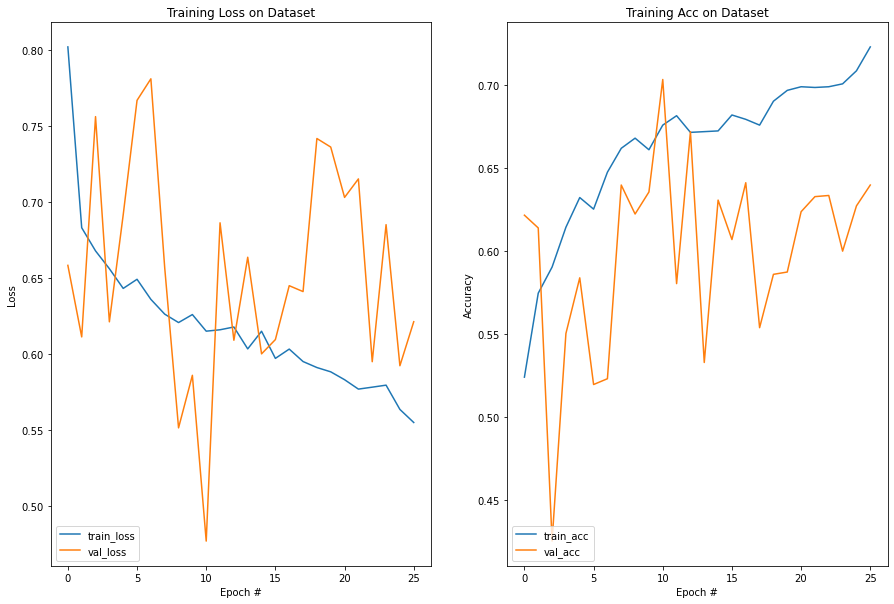

In [34]:
## plot figures
plot_history(history)


(array([0.        , 0.        , 0.05555556, 0.05555556, 0.07407407,
        0.07407407, 0.22222222, 0.22222222, 0.2962963 , 0.2962963 ,
        0.37037037, 0.37037037, 0.62962963, 0.62962963, 0.66666667,
        0.66666667, 0.72222222, 0.72222222, 0.90740741, 0.90740741,
        1.        ]),
 array([0.        , 0.09090909, 0.09090909, 0.18181818, 0.18181818,
        0.27272727, 0.27272727, 0.36363636, 0.36363636, 0.45454545,
        0.45454545, 0.54545455, 0.54545455, 0.63636364, 0.63636364,
        0.72727273, 0.72727273, 0.81818182, 0.81818182, 1.        ,
        1.        ]))

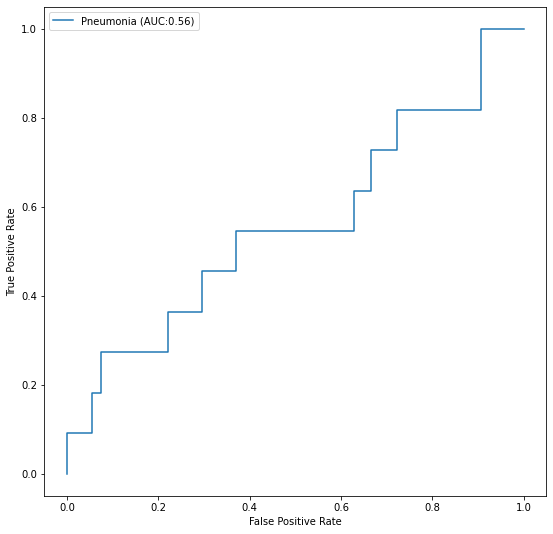

In [35]:
plot_roc(valY, pred_Y)

In [36]:
# valY

In [37]:
# pred_Y

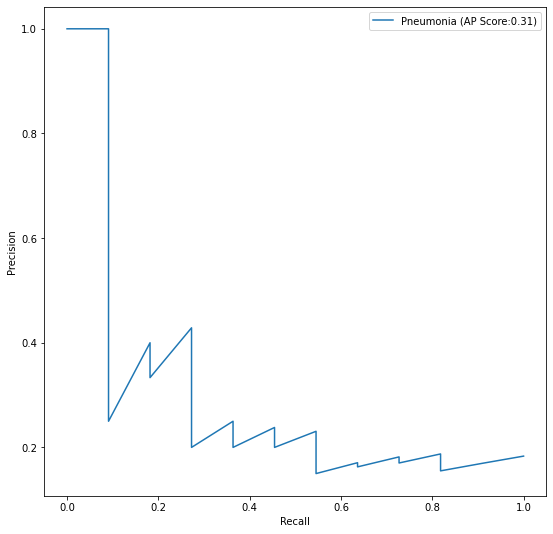

In [38]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

NOTE: optimize for high precision, since pneumonia isn't as emergent as 
    something like a brain bleed, where a patient will die within
    hours if it goes undetected.
    
    Optimizing for precision allows us to be sure of a diagnosis (confirming a diagnosis).
    So if a patient is already displaying outer symptoms of pneumonia, a doctor
    will most likely have an xray ordered to be sure/confirm it is pneumonia.

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
## pick val for threshold_val, send in precision, recall, thresholds arrays, and declare
## either prec_thres or recall_thresh as true, depending on if you want to
## favor precision or recall
threshold_val = 0.5
f1_at_threshold(threshold_val, precision, recall, thresholds, prec_thresh=false, recall_thresh=false)

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)